In [1]:
from random import random
import matplotlib.pyplot as plt
import pymysql

In [4]:
class Produto():
    def __init__(self, nome, espaco, valor):
        self.nome = nome
        self.espaco = espaco
        self.valor = valor

In [8]:
class Individuo():
    def __init__(self, espacos, valores, limite_espacos, geracao=0):
        self.espacos = espacos
        self.valores = valores
        self.limite_espacos= limite_espacos
        self.geracao = geracao
        self.nota_avaliacao = 0
        self.cromossomo = []
        self.espaco_usado = 0
        for i in range(len(espacos)):
            if random() < 0.5:
                self.cromossomo.append(0)
            else:
                self.cromossomo.append(1)
                
    def avaliacao(self):
        nota = 0
        soma_espacos = 0
        for i in range(len(self.cromossomo)):
            if self.cromossomo[i] == 1:
                nota += self.valores[i]
                soma_espacos += self.espacos[i]
            if soma_espacos > self.limite_espacos:
                nota = 1
        self.nota_avaliacao = nota
        self.espaco_usado = soma_espacos
        
    def crossover(self, outro_individuo):
        corte = round(random()  * len(self.cromossomo))
        
        filho1 = outro_individuo.cromossomo[0:corte] + self.cromossomo[corte::]
        filho2 = self.cromossomo[0:corte] + outro_individuo.cromossomo[corte::]
        
        filhos = [Individuo(self.espacos, self.valores, self.limite_espacos, self.geracao + 1),
                  Individuo(self.espacos, self.valores, self.limite_espacos, self.geracao + 1)]
        filhos[0].cromossomo = filho1
        filhos[1].cromossomo = filho2
        return filhos
    
    def mutacao(self, taxa_mutacao):
        for i in range(len(self.cromossomo)):
            if random() < taxa_mutacao:
                if self.cromossomo[i] == '1':
                    self.cromossomo[i] = '0'
                else:
                    self.cromossomo[i] = '1'
        return self

In [9]:
class Algoritmogenetico():
    def __init__(self, tamanhoPopulacao):
        self.tamanhoPopulacao = tamanhoPopulacao
        self.populacao = []
        self.geracao = 0
        self.melhorsolucao = 0
        self.lista_solucoes = []
    def inicilizaPopulacao(self, espacos, valores, limite_espacos):
        for i in range(self.tamanhoPopulacao):
            self.populacao.append(Individuo(espacos, valores, limite_espacos))
        self.melhorsolucao = self.populacao[0]
    
    def ordenaPopulacao(self):
        self.populacao = sorted(self.populacao, key = lambda populacao : populacao.nota_avaliacao,
                               reverse = True)
    def melhorIndividuo(self, individuo):
        if individuo.nota_avaliacao > self.melhorsolucao.nota_avaliacao:
            self.melhorsolucao = individuo
    
    def somaAvaliacoes(self):
        soma = 0
        for individuo in self.populacao:
            soma += individuo.nota_avaliacao
        return soma
    
    def selecionaPai(self, soma_avaliacao):
        pai = -1
        valor_sorteado = random() * soma_avaliacao
        soma = 0
        i = 0
        while i < len(self.populacao) and soma < valor_sorteado:
            soma += self.populacao[i].nota_avaliacao
            pai += 1
            i += 1
        return pai
    
    def visualizaGeracao(self):
        melhor = self.populacao[0]
        print('Geracao: %s' % self.populacao[0].geracao)
        print('Melhor solucao pro problema: %s' % melhor.cromossomo,
     '\nNota = %s' % melhor.nota_avaliacao, 
     '\nTamanho = %s' % melhor.espaco_usado)
    
    def resolver(self, taxa_mutacao, numero_geracoes, espacos, valores, limite_espacos):
        self.inicilizaPopulacao(espacos, valores, limite_espacos)
        
        for individuo in self.populacao:
            individuo.avaliacao()
        self.ordenaPopulacao()
        self.melhorsolucao = self.populacao[0]
        self.lista_solucoes.append(self.melhorsolucao.nota_avaliacao)
        self.visualizaGeracao()
        
        for geracao in range(numero_geracoes):
            soma_avaliacao = self.somaAvaliacoes()
            nova_populacao = []
            
            for individuos_gerados in range(0, self.tamanhoPopulacao):
                pai1 = self.selecionaPai(soma_avaliacao)
                pai2 = self.selecionaPai(soma_avaliacao)
                
                filhos = self.populacao[pai1].crossover(self.populacao[pai2])
                nova_populacao.append(filhos[0].mutacao(taxa_mutacao))
                nova_populacao.append(filhos[1].mutacao(taxa_mutacao))
                                      
            self.populacao = nova_populacao
            for individuo in self.populacao:
                individuo.avaliacao()
            self.ordenaPopulacao()
            self.visualizaGeracao()
            self.melhorIndividuo(self.populacao[0])
            self.lista_solucoes.append(self.populacao[0].nota_avaliacao)

        print('Melhor solucao pro problema: %s' % self.melhorsolucao.geracao, '\nNota = %s' % self.melhorsolucao.nota_avaliacao, '\nTamanho = %s' % self.melhorsolucao.espaco_usado,
     '\nCromossomo = %s' % self.melhorsolucao.cromossomo)
        return self.melhorsolucao.cromossomo

In [14]:
lista_produtos = []
conexao = pymysql.connect(host='db4free.net', user='vanderson', passwd='Vfs@001122', db='teste_vanderson')
cursor = conexao.cursor()
cursor.execute('SELECT nome, espaco, valor, quantidade FROM produtos')
for produto in cursor:
    for i in range(produto[3]):
        lista_produtos.append(Produto(produto[0], produto[1], produto[2]))
cursor.close()
conexao.close()

In [21]:
espacos = []
valores = []
nomes = []
limite = 4
for produto in lista_produtos:
    espacos.append(produto.espaco)
    valores.append(produto.valor)
    nomes.append(produto.nome)
tamanho_populacao = 1000
taxa_mutacao = 0.02
numero_geracoes = 100
ag = Algoritmogenetico(tamanho_populacao)
resultado = ag.resolver(taxa_mutacao, numero_geracoes, espacos, valores, limite)
for i in range(len(lista_produtos)):
    if resultado[i] == 1:
        print("Nome: %s R$ %s " % (lista_produtos[i].nome, lista_produtos[i].valor))

Geracao: 0
Melhor solucao pro problema: [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 
Nota = 31071.040000000005 
Tamanho = 3.0651797999999997
Geracao: 1
Melhor solucao pro problema: [0, 1, '1', 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, '1', 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 
Nota = 37617.15000000001 
Tamanho = 3.4652697
Geracao: 2
Melhor solucao pro problema: [0, 1, '1', 0, 1, 1, 1, '1', 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, '1', 0, 0, 0] 
Nota = 40616.150000000016 
Tamanho = 3.6652696999999996
Geracao: 3
Melhor solucao pro problema: [0, 0, 1, 0, 1, '1', 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, '1', 0, 0, '1', 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1] 
Nota = 40736.96000000001 
Tamanho = 3.1999797999999995
Geracao: 4
Melhor solucao pro problema:

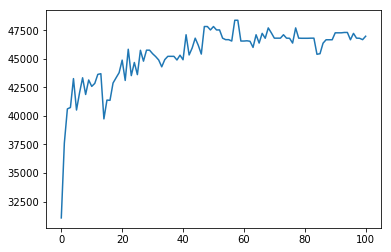

In [22]:
plt.plot(ag.lista_solucoes)
plt.show()